# Imports

In [3]:
import numpy as np
import trimesh
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import os

### Load - Point_clouds

In [21]:
point_clouds = []
num_scans = 30
base_folder = "KITTI-Sequence" 

print(f"Iniciando o carregamento a partir da pasta: {base_folder}")

for i in range(num_scans):
    scan_str = f"{i:06d}"
    filename = os.path.join(base_folder, scan_str, f"{scan_str}_points.obj")
    try:
        print(f"Carregando: {filename}")
        pc = trimesh.load(filename).vertices
        point_clouds.append(pc)
    except Exception as e:
        print(f"ERRO: Não foi possível carregar o arquivo {filename}. Verifique se o caminho e a estrutura de pastas estão corretos.")
        print(f"Detalhe do erro: {e}")
        break 

if len(point_clouds) == num_scans:
    print("\nTodos os arquivos de nuvem de pontos foram carregados com sucesso.")
    ground_truth_poses = np.load('ground_truth.npy')
    print("Arquivo ground_truth.npy carregado.")

Iniciando o carregamento a partir da pasta: KITTI-Sequence
Carregando: KITTI-Sequence\000000\000000_points.obj
Carregando: KITTI-Sequence\000001\000001_points.obj
Carregando: KITTI-Sequence\000002\000002_points.obj
Carregando: KITTI-Sequence\000003\000003_points.obj
Carregando: KITTI-Sequence\000004\000004_points.obj
Carregando: KITTI-Sequence\000005\000005_points.obj
Carregando: KITTI-Sequence\000006\000006_points.obj
Carregando: KITTI-Sequence\000007\000007_points.obj
Carregando: KITTI-Sequence\000008\000008_points.obj
Carregando: KITTI-Sequence\000009\000009_points.obj
Carregando: KITTI-Sequence\000010\000010_points.obj
Carregando: KITTI-Sequence\000011\000011_points.obj
Carregando: KITTI-Sequence\000012\000012_points.obj
Carregando: KITTI-Sequence\000013\000013_points.obj
Carregando: KITTI-Sequence\000014\000014_points.obj
Carregando: KITTI-Sequence\000015\000015_points.obj
Carregando: KITTI-Sequence\000016\000016_points.obj
Carregando: KITTI-Sequence\000017\000017_points.obj
Carre

### Best transform

In [22]:
def find_best_transform(A, B):
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    A_centered = A - centroid_A
    B_centered = B - centroid_B
    H = A_centered.T @ B_centered
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
       Vt[2, :] *= -1
       R = Vt.T @ U.T
    t = centroid_B.T - R @ centroid_A.T
    T = np.identity(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

def icp_final(source_points, target_points, max_iterations=20, tolerance=1e-6, sample_size=2000):
    if len(source_points) > sample_size:
        indices = np.random.choice(len(source_points), sample_size, replace=False)
        source_sample = source_points[indices]
    else:
        source_sample = np.copy(source_points)

    kdtree = KDTree(target_points)
    
    total_transform = np.identity(4)

    prev_error = float('inf')

    for i in range(max_iterations):
        source_transformed = (total_transform[:3, :3] @ source_sample.T + total_transform[:3, 3:4]).T

        distances, indices = kdtree.query(source_transformed)
        corresponding_target_points = target_points[indices]
        incremental_transform = find_best_transform(source_transformed, corresponding_target_points)

        total_transform = incremental_transform @ total_transform
 
        mean_error = np.mean(distances**2)
        if abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error
        
    return total_transform, prev_error

### Trajectory

#### New Attempt with pre-processing

Iniciando a estimação final da trajetória com PRÉ-PROCESSAMENTO ROBUSTO (RANSAC)...
Processando scan 1 -> 0 (com 62154 pontos úteis)...
Processando scan 2 -> 1 (com 61955 pontos úteis)...
Processando scan 3 -> 2 (com 61646 pontos úteis)...
Processando scan 4 -> 3 (com 61350 pontos úteis)...
Processando scan 5 -> 4 (com 61188 pontos úteis)...
Processando scan 6 -> 5 (com 60942 pontos úteis)...
Processando scan 7 -> 6 (com 60014 pontos úteis)...
Processando scan 8 -> 7 (com 59369 pontos úteis)...
Processando scan 9 -> 8 (com 58795 pontos úteis)...
Processando scan 10 -> 9 (com 58899 pontos úteis)...
Processando scan 11 -> 10 (com 60661 pontos úteis)...
Processando scan 12 -> 11 (com 61728 pontos úteis)...
Processando scan 13 -> 12 (com 62509 pontos úteis)...
Processando scan 14 -> 13 (com 62944 pontos úteis)...
Processando scan 15 -> 14 (com 63008 pontos úteis)...
Processando scan 16 -> 15 (com 62513 pontos úteis)...
Processando scan 17 -> 16 (com 62894 pontos úteis)...
Processando scan 

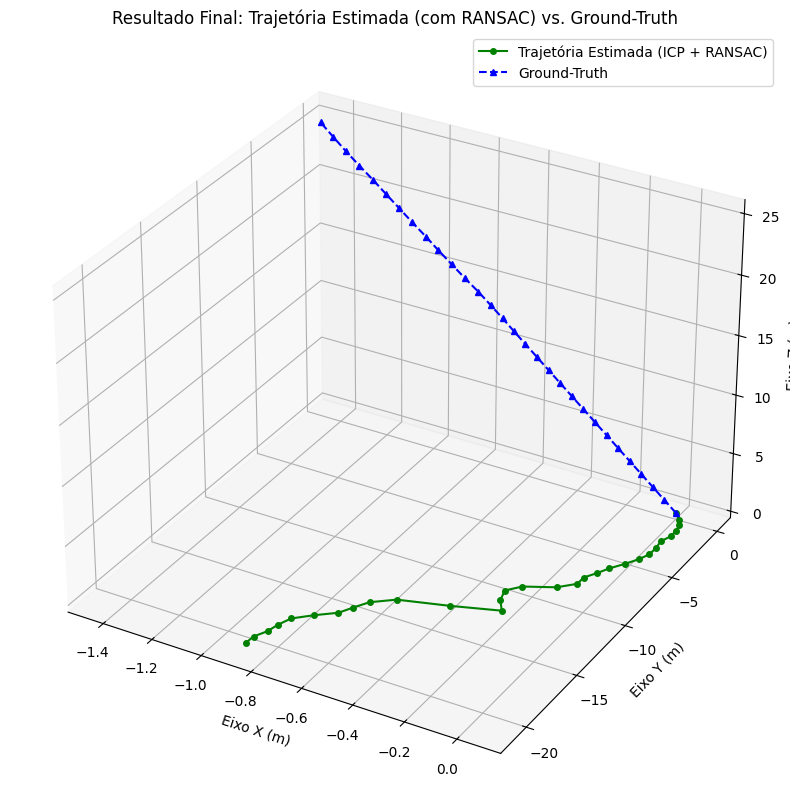


Erro médio da trajetória final: 15.7803 metros


In [26]:
global_pose_final = np.identity(4)
estimated_trajectory_final = [global_pose_final[:3, 3]]

print("Iniciando a estimação final da trajetória com PRÉ-PROCESSAMENTO ROBUSTO (RANSAC)...")

for i in range(len(point_clouds) - 1):
    source_pc_final = preprocess_point_cloud_ransac(point_clouds[i+1])
    target_pc_final = preprocess_point_cloud_ransac(point_clouds[i])
    
    print(f"Processando scan {i+1} -> {i} (com {len(source_pc_final)} pontos úteis)...")
    
    relative_transform, error = icp_final(source_pc_final, target_pc_final)
    
    vehicle_movement = np.linalg.inv(relative_transform)
    global_pose_final = global_pose_final @ vehicle_movement
    estimated_trajectory_final.append(global_pose_final[:3, 3])

estimated_trajectory_final = np.array(estimated_trajectory_final)
print("Estimação da trajetória final concluída!")


gt_trajectory = ground_truth_poses[:, :3, 3]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(estimated_trajectory_final[:, 0], estimated_trajectory_final[:, 1], estimated_trajectory_final[:, 2], 
        label='Trajetória Estimada (ICP + RANSAC)', color='g', marker='o', markersize=4)

ax.plot(gt_trajectory[:, 0], gt_trajectory[:, 1], gt_trajectory[:, 2], 
        label='Ground-Truth', color='b', marker='^', markersize=4, linestyle='--')

ax.set_xlabel('Eixo X (m)')
ax.set_ylabel('Eixo Y (m)')
ax.set_zlabel('Eixo Z (m)')
ax.set_title('Resultado Final: Trajetória Estimada (com RANSAC) vs. Ground-Truth')
ax.legend()
plt.grid(True)
plt.show()

final_error = np.linalg.norm(estimated_trajectory_final - gt_trajectory, axis=1)
print(f"\nErro médio da trajetória final: {np.mean(final_error):.4f} metros")

In [ ]:
from scipy.spatial.transform import Rotation as R


print("--- Iniciando o Teste de Sanidade do ICP ---")

base_pc = preprocess_point_cloud_ransac(point_clouds[5])

rotation_matrix = R.from_euler('z', 15, degrees=True).as_matrix()
translation_vector = np.array([2.0, 5.0, 1.0])

T_ground_truth = np.identity(4)
T_ground_truth[:3, :3] = rotation_matrix
T_ground_truth[:3, 3] = translation_vector

transformed_pc = (rotation_matrix @ base_pc.T + translation_vector[:, np.newaxis]).T

T_estimated, error = icp_final(base_pc, transformed_pc)

print("\n Resultados do Teste de Sanidade")
print("\nMatriz de Transformação Real (que nós aplicamos):")
print(np.round(T_ground_truth, 4))

print("\nMatriz de Transformação Estimada (pelo nosso ICP):")
print(np.round(T_estimated, 4))

translation_error = np.linalg.norm(T_ground_truth[:3, 3] - T_estimated[:3, 3])
print(f"\nErro de Translação: {translation_error:.4f} metros")


if translation_error < 0.1:
    print("\n\033[92mSUCESSO: O algoritmo ICP passou no teste de sanidade! A implementação está correta.\033[0m")
else:
    print("\n\033[91mFALHA: O algoritmo ICP falhou no teste de sanidade. Ainda há um bug na implementação.\033[0m")

--- Iniciando o Teste de Sanidade do ICP ---

--- Resultados do Teste de Sanidade ---

Matriz de Transformação Real (que nós aplicamos):
[[ 0.9659 -0.2588  0.      2.    ]
 [ 0.2588  0.9659  0.      5.    ]
 [ 0.      0.      1.      1.    ]
 [ 0.      0.      0.      1.    ]]

Matriz de Transformação Estimada (pelo nosso ICP):
[[ 9.6640e-01 -2.5720e-01  1.5000e-03  1.9949e+00]
 [ 2.5720e-01  9.6640e-01  6.0000e-04  4.9063e+00]
 [-1.6000e-03 -2.0000e-04  1.0000e+00  9.9280e-01]
 [ 0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00]]

Erro de Translação: 0.0941 metros

SUCESSO: O algoritmo ICP passou no teste de sanidade! A implementação está correta.
